# Importando as bibliotecas

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import time
import psutil
import pandas as pd
import numpy as np

# Montando o Diretório

In [2]:
# Diretórios principais
base_dir = "D:\\T.I\\BootcampAvanti_ML\\DeteccaoMelanoma_ML"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Preparação do Dataset

In [3]:
# Definir tamanho da imagem e tamanho do lote
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Criar o gerador de dados de treinamento com data augmentation e validação
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Usar 20% dos dados para validação
)

# Criar o gerador de dados para treinamento
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Usar a parte de treinamento dos dados
)

# Criar o gerador de dados para validação
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Usar a parte de validação dos dados
)


Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.


#### Salvando o pré processamento usado

In [4]:
# # Salvando o pré processamento

# preprocessing_info = """
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Data Augmentation:
# - Flip horizontal e vertical
# - Rotação aleatória de até 0.3 radianos
# """

# with open('PreProcessing_DenseNet121_model.txt', 'w') as f:
#     f.write(preprocessing_info)


# Visualização dos Dados

In [5]:
# import matplotlib.pyplot as plt

# # Define the number of images to plot from each class
# num_images_per_class = 5

# # Get class indices
# class_indices = train_generator.class_indices

# class_labels = {v: k for k, v in class_indices.items()}

# # Plot images from each class
# for class_index, class_label in class_labels.items():
#     # Find the first num_images_per_class images belonging to the current class
#     class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

#     # Plot the images
#     plt.figure(figsize=(10, 5))
#     for i, image in enumerate(class_images):
#         plt.subplot(1, num_images_per_class, i + 1)
#         plt.imshow(image)
#         plt.title(class_label)
#         plt.axis('off')
#     plt.show()

# Construção do Modelo

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (224, 224, 3)

DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape, pooling='max')

x = DenseNet121_model.output
x = layers.BatchNormalization()(x)
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = models.Model(inputs=DenseNet121_model.input, outputs=output)

#print(model.summary())

In [7]:
# Salvando o Resumo do Modelo

# with open('DenseNet121_model_Summary.txt', 'w') as f:
#     DenseNet121_model.summary(print_fn=lambda x: f.write(x + '\n'))


In [8]:
# Compilando o modelo

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Construindo função para monitorar o treinamento

In [9]:
class ResourceMonitor(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.process = psutil.Process()
        self.cpu_usages = []
        self.memory_usages = []
        self.logs = {
            "epoch": [],
            "cpu_usage": [],
            "memory_usage": [],
            "elapsed_time": []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Capture CPU and memory usage at the end of each epoch
        cpu_usage = self.process.cpu_percent(interval=None)
        memory_info = self.process.memory_info()
        memory_usage = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
        elapsed_time = time.time() - self.train_start_time
        
        self.cpu_usages.append(cpu_usage)
        self.memory_usages.append(memory_usage)

        # Store in logs
        self.logs["epoch"].append(epoch + 1)
        self.logs["cpu_usage"].append(cpu_usage)
        self.logs["memory_usage"].append(memory_usage)
        self.logs["elapsed_time"].append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU usage: {cpu_usage}%, Memory usage: {memory_usage} MB, Elapsed time: {elapsed_time:.2f} seconds")
    
    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        self.total_training_time = self.train_end_time - self.train_start_time
        print(f"Total training time: {self.total_training_time:.2f} seconds")
        print(f"Average CPU usage: {sum(self.cpu_usages) / len(self.cpu_usages):.2f}%")
        print(f"Average Memory usage: {sum(self.memory_usages) / len(self.memory_usages):.2f} MB")
        
        # Store final training time
        self.logs["total_training_time"] = self.total_training_time
        self.logs["average_cpu_usage"] = sum(self.cpu_usages) / len(self.cpu_usages)
        self.logs["average_memory_usage"] = sum(self.memory_usages) / len(self.memory_usages)
    
    def get_logs(self):
        return self.logs
    

resource_monitor = ResourceMonitor()

# Treinando o modelo

In [10]:
history = model.fit(
    train_generator,
    epochs=30,  # ou o número de épocas desejado
    validation_data=validation_generator,
    callbacks=[resource_monitor]  # Inclua o callback aqui
)


# Converter os logs para um DataFrame
logs = resource_monitor.get_logs()
df = pd.DataFrame(logs)
print(df)

Epoch 1/30


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8065 - loss: 0.6955Epoch 1: CPU usage: 0.0%, Memory usage: 6068.3359375 MB, Elapsed time: 2207.40 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 2207s 7s/step - accuracy: 0.8067 - loss: 0.6951 - val_accuracy: 0.7861 - val_loss: 0.7253
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8751 - loss: 0.4886Epoch 2: CPU usage: 653.4%, Memory usage: 5100.546875 MB, Elapsed time: 4307.14 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 2100s 7s/step - accuracy: 0.8751 - loss: 0.4885 - val_accuracy: 0.7815 - val_loss: 0.6852
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8893 - loss: 0.4264Epoch 3: CPU usage: 653.3%, Memory usage: 5101.8203125 MB, Elapsed time: 6407.12 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 2100s 7s/step - accuracy: 0.8894 - loss: 0.4264 - val_accuracy: 0.8248 - val_loss: 0.5360
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9071 - loss: 0.3867Epoch 4: CPU usage: 649.4%, Memory usage: 4937.3632812

# Monitorando o Treinamento

In [11]:
# Salvando o monitoramento de recursos.

df.to_csv('resource_usage_log_DenseNet121-30ep_model.csv', index=False)

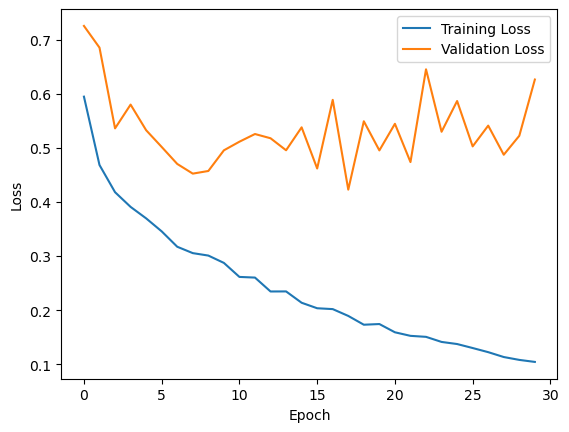

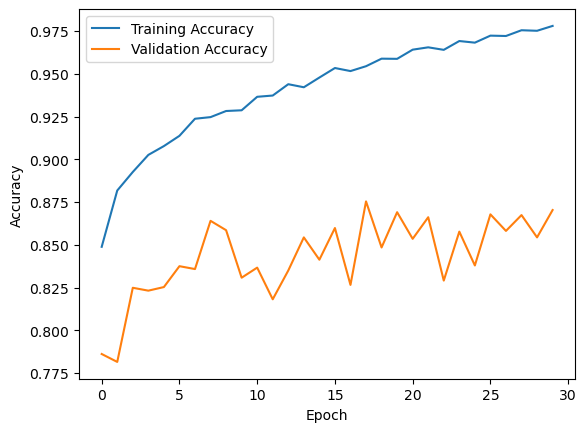

In [12]:
# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a acurácia de treinamento e validação
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Salvando o modelo:

In [13]:
# Salvar o modelo completo no formato Keras nativo
model.save('DenseNet121_model-30Ep.keras')

# Avaliar o modelo no conjunto de Test

#### Preparando o conjunto de teste

In [20]:
# Criando o gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Caminho para o diretório de teste
    target_size=(224, 224),  # Tamanho das imagens
    batch_size=32,
    class_mode='categorical',  # Usando 'categorical' para classes múltiplas
    shuffle=True  # Não é necessário embaralhar para avaliação
)

Found 2000 images belonging to 2 classes.


In [21]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9315 - loss: 0.3523
Perda no teste: 0.3772
Acurácia no teste: 0.9225


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def evaluate_model(model, test_dataset):
    # Avaliar o modelo no conjunto de teste
    scores = model.evaluate(test_dataset)
    print(f"Loss: {scores[0]}")
    print(f"Accuracy: {scores[1]}")
    
    # Obter previsões
    y_true = test_dataset.classes  # Classes verdadeiras
    y_pred = np.argmax(model.predict(test_dataset), axis=-1)  # Classes preditas
    
    # Relatório de classificação
    print("Classification Report")
    class_report = classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {
        "loss": scores[0],
        "accuracy": scores[1],
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "classification_report": class_report
    }
    
    # Converter as métricas em um DataFrame
    metrics_df = pd.DataFrame([metrics])
    
    return metrics_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9509 - loss: 0.1980
Loss: 0.37720465660095215
Accuracy: 0.9225000143051147
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step
Classification Report
              precision    recall  f1-score   support

     Benigno       0.89      0.96      0.93      1000
     Maligno       0.96      0.88      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000



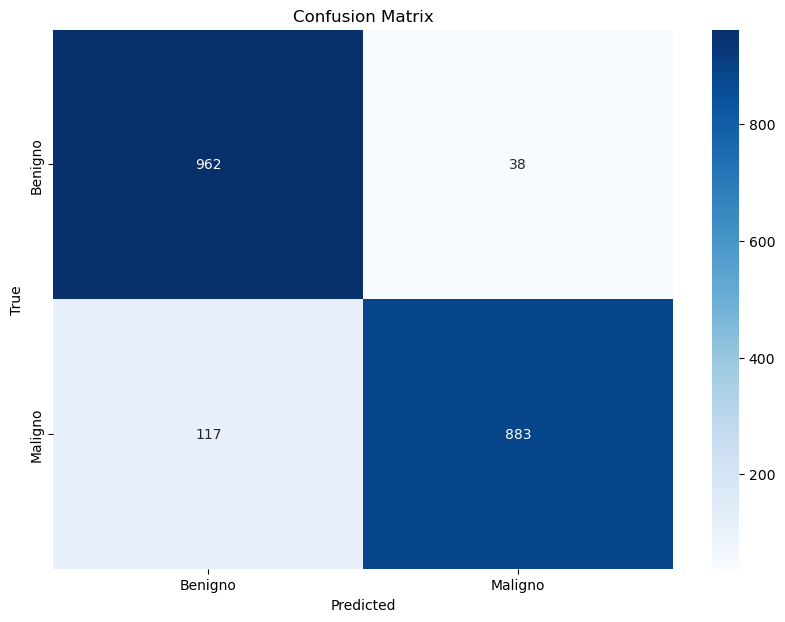

,loss,accuracy,precision,recall,f1_score,classification_report
0,0.377205,0.9225,0.925153,0.9225,0.922379,"{'Benigno': {'precision': 0.891566265060241, '..."


In [17]:
# Avaliar o modelo e obter as métricas
metrics_df = evaluate_model(model, test_generator)
display(metrics_df)


#### Salvando report

In [18]:
# Salvar o DataFrame em um arquivo CSV
metrics_df.to_csv('model_DenseNet121-30Ep_metrics.csv', index=False)

# Predições

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


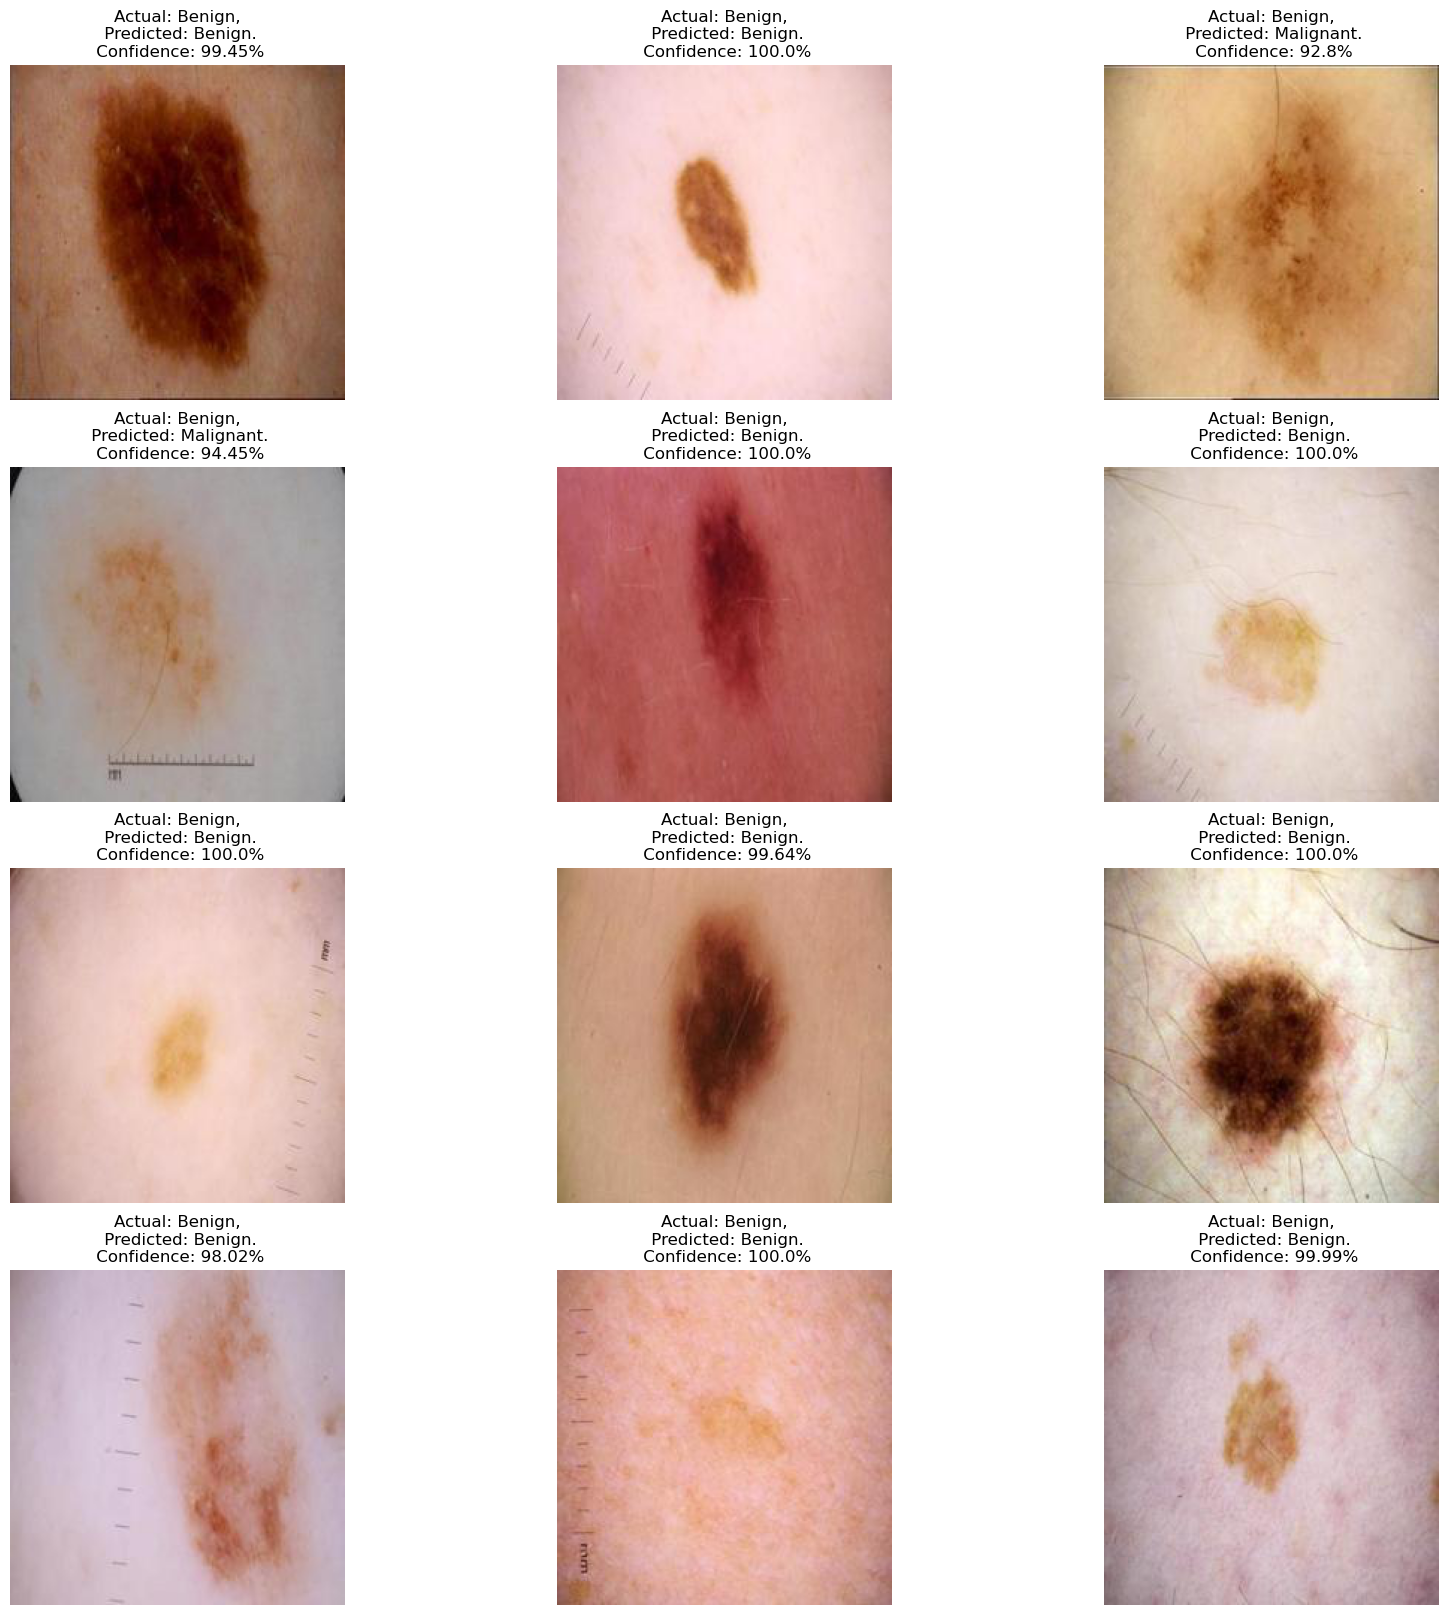

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Expande a dimensão para (1, height, width, channels)

    predictions = model.predict(img_array)
    # Converter as chaves do dicionário para uma lista para acessar os índices
    predicted_class = list(test_generator.class_indices.keys())[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(20, 20))

# Obtém um lote de imagens e rótulos do gerador
images, labels = next(test_generator)

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i])

    predicted_class, confidence = predict(model, images[i])
    # Converter as chaves do dicionário para uma lista para acessar os índices
    actual_class = list(test_generator.class_indices.keys())[np.argmax(labels[i])]
    
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

plt.show()
